In [1]:
import os
import cv2
import pickle
import numpy as np
import open3d as o3d
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# **Question: 5 - Camera-LIDAR Cross-Calibration**

## **Visualization of Images**

We first visualize the images we will use to cross-calibrate the camera. The images are from the dataset given in the `Datasets/LIDAR` directory. We will use these images to calibrate the camera and obtain the intrinsic matrix and distortion coefficients, and extrinsic matrix for each image, among other tasks.

In [2]:
sample = 25
base = r"Datasets/LIDAR/"
image_dir = os.path.join(base, r"camera_images/")
param_dir = os.path.join(base, r"camera_parameters/")
lidar_dir = os.path.join(base, r"lidar_scans/")

images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)][:sample]
params = [os.path.join(param_dir, param) for param in os.listdir(param_dir) if not param.endswith(".txt")][:sample]
lidars = [os.path.join(lidar_dir, lidar) for lidar in os.listdir(lidar_dir)][:sample]

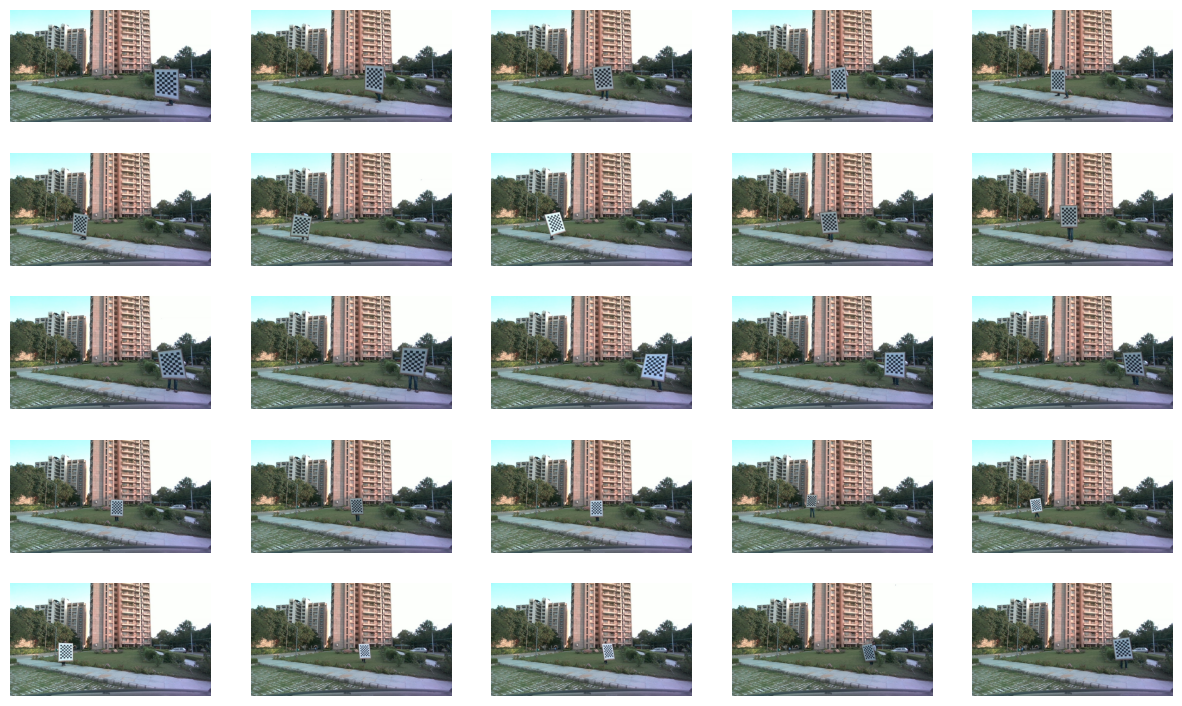

In [3]:
plt.figure(figsize=(15, 9))
for i, image in enumerate(images[:sample]):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.axis("off")
plt.show()

## **1. Chessboard Normals**

We compute the normals to the chessboard and their offsets in each image using the planar LIDAR points from the `.pcd` files using Singular Value Decomposition (SVD). These normals are in the LIDAR coordinate frame.

In [4]:
normals_l = np.zeros((sample, 3))
offsets_l = np.zeros(sample)

for i, scan in enumerate(lidars):
    point_cloud = o3d.io.read_point_cloud(scan)
    points = np.asarray(point_cloud.points)
    centered = points - np.mean(points, axis=0)
    U, S, Vt = np.linalg.svd(centered, full_matrices=False)
    normal = Vt[-1]
    offset = -np.dot(normal, np.mean(points, axis=0))
    if offset < 0:
        normal, offset = -normal, -offset
    normals_l[i] = normal
    offsets_l[i] = offset
    print(f"Image: {scan.split('/')[-1]}\t ", f"Normal: {np.round(normal, 5)}", f"Offset: {offset:.5f}", sep="\t")

Image: frame_1061.pcd	 	Normal: [-0.63693  0.765   -0.09535]	Offset: 4.99381
Image: frame_1075.pcd	 	Normal: [-0.7017   0.70119 -0.12631]	Offset: 4.72078
Image: frame_1093.pcd	 	Normal: [-0.93809  0.22959 -0.25937]	Offset: 5.20431
Image: frame_1139.pcd	 	Normal: [-0.72353  0.68813  0.05468]	Offset: 4.79350
Image: frame_1153.pcd	 	Normal: [-0.83334  0.55208 -0.02752]	Offset: 5.22080
Image: frame_1163.pcd	 	Normal: [-0.91935  0.3607  -0.15711]	Offset: 5.70252
Image: frame_1195.pcd	 	Normal: [-0.94151 -0.1895  -0.27866]	Offset: 6.32357
Image: frame_1366.pcd	 	Normal: [-0.81879 -0.50764  0.26813]	Offset: 6.44544
Image: frame_1430.pcd	 	Normal: [-0.93288  0.24404 -0.26491]	Offset: 5.67426
Image: frame_1473.pcd	 	Normal: [-0.95207  0.15397 -0.2643 ]	Offset: 5.74369
Image: frame_1558.pcd	 	Normal: [-0.60407  0.77413 -0.18926]	Offset: 5.06235
Image: frame_1580.pcd	 	Normal: [-0.75933  0.56255 -0.32705]	Offset: 4.95402
Image: frame_1638.pcd	 	Normal: [-0.47346  0.75992  0.44537]	Offset: 5.25498

## **2. Equations for estimating transformation matrix $^{\mathbf{C}} \mathbf{T}_{\mathbf{L}}$**

Using the normals and offsets in the LIDAR coordinate frame and the normals and offsets in the camera coordinate frame (given in the dataset), we derive the set of equations we can use to estimate the transformation matrix 

$$^{\mathbf{C}} \mathbf{T}_{\mathbf{L}} = \begin{bmatrix} ^{\mathbf{C}} \mathbf{R}_{\mathbf{L}} \mid \ ^{\mathbf{C}} t_{\mathbf{L}} \end{bmatrix}$$

where $^\mathbf{C} \mathbf{R}_\mathbf{L}$ is the rotation matrix and $^{\mathbf{C}} t_{\mathbf{L}}$ is the translation vector from the LIDAR coordinate frame to the camera coordinate frame. We make use of the formulas given in the reference thesis to derive these equations. Let's say we have the LIDAR data and image data for $n$ images (in our case, $n = 25$). Then, the equations are given by

In [5]:
normals_c = np.zeros((sample, 3))
offsets_c = np.zeros(sample)

for i, param in enumerate(params):
    camera_normals = os.path.join(param, r"camera_normals.txt")
    translation_vectors = os.path.join(param, r"translation_vectors.txt")

    with open(camera_normals) as normal, open(translation_vectors) as translation:
        normal = np.array([float(x) for x in normal.readlines()])
        tvec = np.array([float(x) for x in translation.readlines()])

    normals_c[i] = normal
    offsets_c[i] = -np.dot(normal, tvec)
    if offsets_c[i] < 0:
        normals_c[i], offsets_c[i] = -normals_c[i], -offsets_c[i]

## **3. Calculating Transformation Matrix $^{\mathbf{C}} \mathbf{T}_{\mathbf{L}}$**

We now calculate the Transformation Matrix $^{\mathbf{C}} \mathbf{T}_{\mathbf{L}}$ using the equations derived in the previous step using the closed form solution given in the thesis. We use the normals and offsets in the LIDAR coordinate frame and the normals and offsets in the camera coordinate frame to calculate the transformation matrix.

According to the thesis, if

$$
    \mathbf{n}_{C} = \begin{bmatrix} \hat{\mathbf{n}}_{1}^{(C)} \\ \hat{\mathbf{n}}_{2}^{(C)} \\ \vdots \\ \hat{\mathbf{n}}_{n}^{(C)} \end{bmatrix}_{n \times 3} \quad
    \mathbf{n}_{L} = \begin{bmatrix} \hat{\mathbf{n}}_{1}^{(L)} \\ \hat{\mathbf{n}}_{2}^{(L)} \\ \vdots \\ \hat{\mathbf{n}}_{n}^{(L)} \end{bmatrix}_{n \times 3} \quad
    \mathbf{d}_{C} = \begin{bmatrix} d_{1}^{(C)} \\ d_{2}^{(C)} \\ \vdots \\ d_{n}^{(C)} \end{bmatrix}_{n \times 1} \quad
    \mathbf{d}_{L} = \begin{bmatrix} d_{1}^{(L)} \\ d_{2}^{(L)} \\ \vdots \\ d_{n}^{(L)} \end{bmatrix}_{n \times 1}    
$$

then

$$\begin{align*}
    ^{\mathbf{C}} t_{\mathbf{L}} &= (\mathbf{n}_{C}^{\top} \mathbf{n}_{C})^{-1} \mathbf{n}_{C}^{\top} (d_{L} - d_{C}) \\
    ^{\mathbf{C}} \mathbf{R}_{\mathbf{L}} &= V U^{\top} \quad \text{if} \quad \mathbf{n}_{L}^{\top} \mathbf{n}_{C} = U S V^{\top}
\end{align*}$$

where $\mathbf{n}_{C}$ and $\mathbf{n}_{L}$ are the matrices of normals in the camera and LIDAR coordinate frames, $\mathbf{d}_{C}$ and $\mathbf{d}_{L}$ are the vectors of offsets in the camera and LIDAR coordinate frames, and $U$, $S$, and $V$ are the matrices obtained from the Singular Value Decomposition (SVD) of $\mathbf{n}_{L}^{\top} \mathbf{n}_{C}$. Then, the transformation matrix is simply

$$^{\mathbf{C}} \mathbf{T}_{\mathbf{L}} = \begin{bmatrix} ^{\mathbf{C}} \mathbf{R}_{\mathbf{L}} \mid \ ^{\mathbf{C}} t_{\mathbf{L}} \end{bmatrix}$$

In [6]:
TRANSLATION_VECTOR = np.linalg.pinv(normals_c) @ (offsets_l - offsets_c)
U, S, Vt = np.linalg.svd(normals_l.T @ normals_c, full_matrices=False)
ROTATION_MATRIX = Vt.T @ U.T

In [7]:
TRANSLATION_VECTOR

array([ 0.15017004, -0.41198374, -0.60030909])

In [8]:
ROTATION_MATRIX

array([[-0.17934806, -0.98377389, -0.00481772],
       [ 0.01810312,  0.00159606, -0.99983485],
       [ 0.98361911, -0.17940566,  0.01752313]])

In [9]:
CTL = np.hstack((ROTATION_MATRIX, TRANSLATION_VECTOR.reshape(-1, 1)))
CTL

array([[-0.17934806, -0.98377389, -0.00481772,  0.15017004],
       [ 0.01810312,  0.00159606, -0.99983485, -0.41198374],
       [ 0.98361911, -0.17940566,  0.01752313, -0.60030909]])

## **4. Projecting LIDAR points to image space**

We project the LIDAR points to the image space using the transformation matrix $^{\mathbf{C}} \mathbf{T}_{\mathbf{L}}$ and the intrinsic matrix of the camera. We then visualize the projected points on the image. It is easy to see that in some images, all points are not within the checkerboard pattern's boundary; however, they are close by.

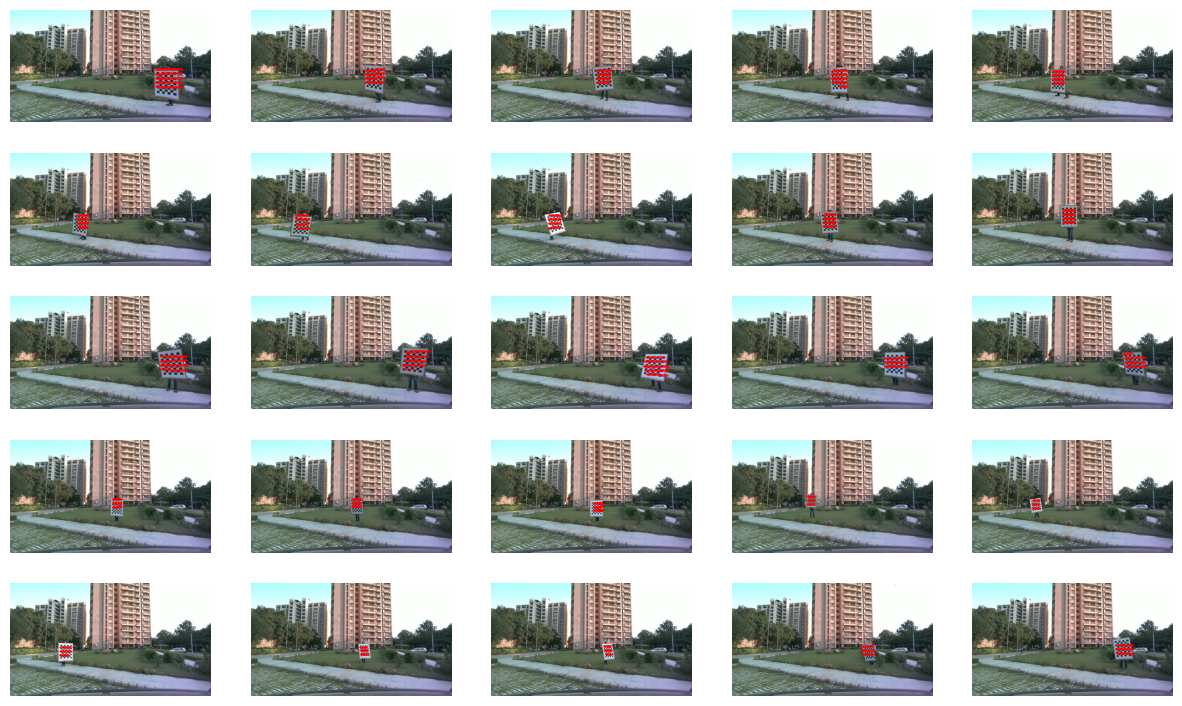

In [10]:
with open(os.path.join(param_dir, "camera_intrinsic.txt")) as intrinsic:
    camera_matrix = np.array([float(x) for x in intrinsic.read().split()]).reshape(3, 3)

plt.figure(figsize=(15, 9))
for i, (image, scan) in enumerate(zip(images, lidars)):
    point_cloud = o3d.io.read_point_cloud(scan)
    points = np.asarray(point_cloud.points)
    points = np.hstack((points, np.ones((points.shape[0], 1)))).T
    projected = camera_matrix @ CTL @ points
    projected = (projected / projected[2])[:2]
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.scatter(projected[0], projected[1], s=0.5, marker=".", color="red")
    plt.axis("off")

plt.show()

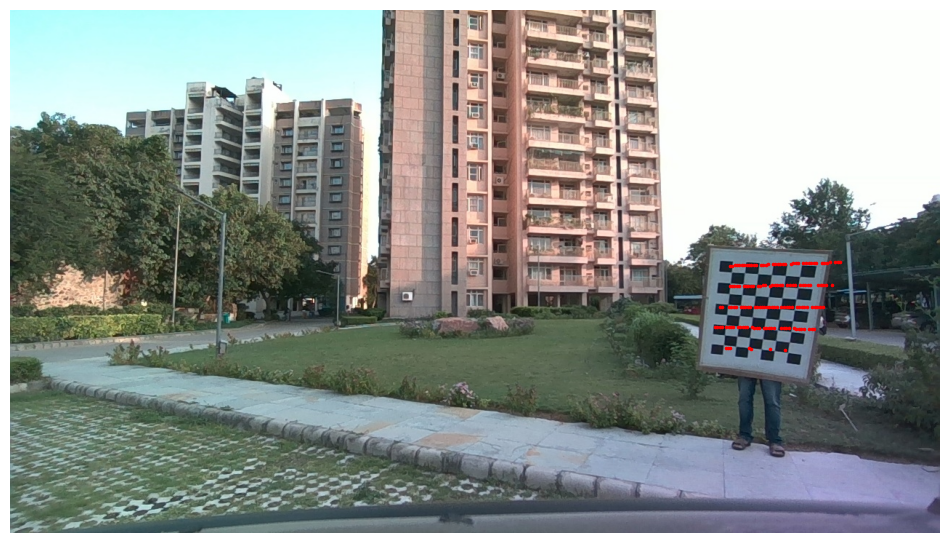

In [11]:
plt.figure(figsize=(12, 9))

index = 11
image, scan = images[index], lidars[index]

point_cloud = o3d.io.read_point_cloud(scan)
points = np.asarray(point_cloud.points)
points = np.hstack((points, np.ones((points.shape[0], 1)))).T
projected = camera_matrix @ CTL @ points
projected = (projected / projected[2])[:2]
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.scatter(projected[0], projected[1], s=10, marker=".", color="red")
plt.axis("off")

plt.show()

## **5. Visualization of the normals**

We visualize the chessboard normals $\hat{\mathbf{n}}_{i}^{L}$ and $\hat{\mathbf{n}}_{i}^{C}$ on all 38 images. We also compute the cosine distance between the camera normal $\hat{\mathbf{n}}_{i}^{C}$ and the transformed LIDAR normal $^{\mathbf{C}} \mathbf{R}_{\mathbf{L}} \hat{\mathbf{n}}_{i}^{L}$ and plot their distribution and mean.

In [12]:
all_images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
all_params = [os.path.join(param_dir, param) for param in os.listdir(param_dir) if not param.endswith(".txt")]
all_lidars = [os.path.join(lidar_dir, lidar) for lidar in os.listdir(lidar_dir)]

errors = np.zeros(len(all_images), dtype=np.float64)

for i, (image, param, scan) in enumerate(zip(all_images, all_params, all_lidars)):
    camera_normals = os.path.join(param, r"camera_normals.txt")
    translation_vectors = os.path.join(param, r"translation_vectors.txt")

    with open(camera_normals) as normal, open(translation_vectors) as translation:
        normal_c = np.array([float(x) for x in normal.readlines()])
        tvec = np.array([float(x) for x in translation.readlines()])

    normal_c *= np.sign(-np.dot(normal_c, tvec))

    points = np.asarray(o3d.io.read_point_cloud(scan).points)
    mean = np.mean(points, axis=0)
    normal_l = np.linalg.svd(points - mean, full_matrices=False)[-1][-1]
    normal_l *= np.sign(-np.dot(normal_l, mean))

    errors[i] = (1 - np.dot(normal_c, normal_l)) / 2

Mean Cosine Distance: 0.45254
Standard Deviation of Cosine Distance: 0.20786


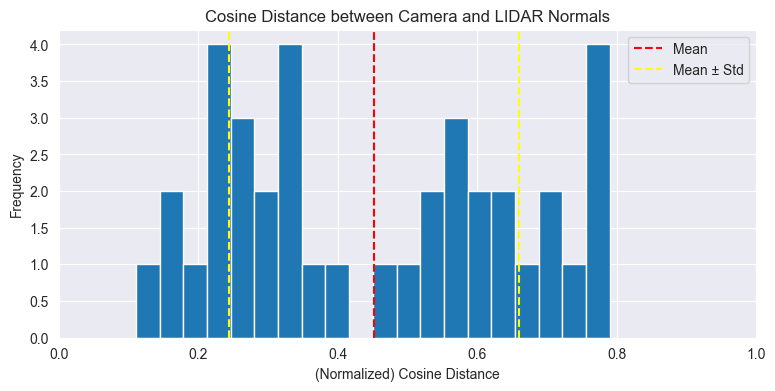

In [13]:
plt.figure(figsize=(9, 4))

mean = np.mean(errors)
std = np.std(errors)
print(f"Mean Cosine Distance: {mean:.5f}")
print(f"Standard Deviation of Cosine Distance: {std:.5f}", sep="\t")

plt.hist(errors, bins=20)
plt.axvline(mean, color="red", linestyle="--", label=f"Mean")
plt.axvline(mean+std, color="yellow", linestyle="--")
plt.axvline(mean-std, color="yellow", linestyle="--", label=f"Mean \u00B1 Std")

plt.xlabel("(Normalized) Cosine Distance")
plt.ylabel("Frequency")
plt.xlim(0.0, 1.0)
plt.title("Cosine Distance between Camera and LIDAR Normals")

plt.legend()
plt.show()